# Sentiment Analysis with Recurrent Neural Networks (RNN) and LSTM

#### Getting the data

In [14]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

#nltk.download('all')    # run just once

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, LSTM, Dropout, Activation, Flatten, Input, SimpleRNN
from keras.callbacks import EarlyStopping

In [2]:
# import data from txt
imdb = pd.read_csv('../data/imdb_labelled.txt', sep='\t', header=None)
imdb.head()

,0,1
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [3]:
amazon = pd.read_csv('../data/amazon_cells_labelled.txt', sep='\t', header=None)
amazon.head()

,0,1
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [4]:
yelp = pd.read_csv('../data/yelp_labelled.txt', sep='\t', header=None)
yelp.head()

,0,1
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [5]:
# merge the datasets
data = pd.merge(imdb, amazon, how='outer')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1748 entries, 0 to 1747
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       1748 non-null   object
 1   1       1748 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 27.4+ KB


In [6]:
data = pd.merge(data, yelp, how='outer')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2748 entries, 0 to 2747
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       2748 non-null   object
 1   1       2748 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 43.1+ KB


In [7]:
data.columns

Index([0, 1], dtype='int64')

In [8]:
data[1].value_counts()

1
1    1386
0    1362
Name: count, dtype: int64

Where '0' is the positive reviews and '1' is the negative reviews

In [10]:
data.isna().sum()

0    0
1    0
dtype: int64

In [7]:
data.duplicated().sum()

17

In [8]:
data = data.drop_duplicates() 
data.duplicated().sum()

0

Text(0.5, 1.0, 'positive vs negative reviews')

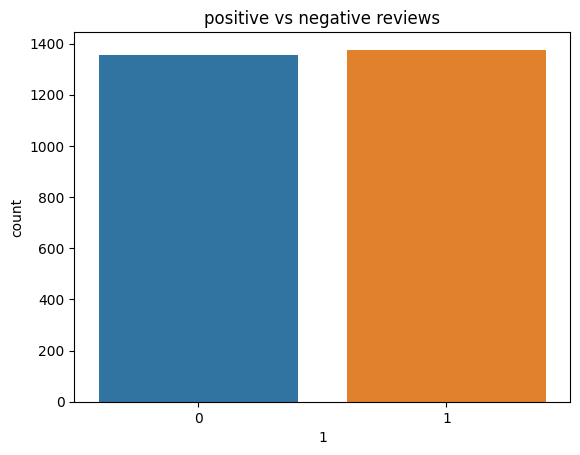

In [15]:
sns.countplot(x=1, data=data)
plt.title("positive vs negative reviews")

In [9]:
# Cree una función para preprocesar el texto
def preprocess_text(text):
    # Tokenice el texto utilizando la función word_tokenize()
    tokens = word_tokenize(text)

    # Pase el texto a minúscula
    tokens = [token.lower() for token in tokens]

    # Elimine las stopwords utilizando stopwords.words('english')
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lematice los tokens utilizando WordNetLemmatizer()
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Una los tokens de los procesos previos en una sola cadena
    processed_text = ' '.join(tokens)

    # Retorne el texto procesado
    return processed_text

# Aplique su función a la columna reviewText del dataframe
data[0] = data[0].apply(preprocess_text)

In [10]:
data.head()

,0,1
0,", , slow-moving , aimless movie distressed , d...",0
1,"sure lost - flat character audience , nearly h...",0
2,attempting artiness black & white clever camer...,0
3,little music anything speak .,0
4,best scene movie gerardo trying find song keep...,1


In [11]:
X = data[0]
y = data[1]

# Divida el dataframe en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
# Implement a DummyClassifier
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()
dummy.fit(X_train, y_train)
y_pred_train = dummy.predict(X_train)
y_pred_test = dummy.predict(X_test)

In [53]:
# print accuracy, precision, recall and f1-score
print("TRAIN METRICS\n")

print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("Precision:", precision_score(y_train, y_pred_train, average='macro'))
print("Recall:", recall_score(y_train, y_pred_train, average='macro'))
print("f1-score:", f1_score(y_train, y_pred_train, average='macro'))
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))


TRAIN METRICS

Accuracy: 0.5023547880690737
Precision: 0.25117739403453687
Recall: 0.5
f1-score: 0.3343782654127482
[[  0 951]
 [  0 960]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       951
           1       0.50      1.00      0.67       960

    accuracy                           0.50      1911
   macro avg       0.25      0.50      0.33      1911
weighted avg       0.25      0.50      0.34      1911



C:\Users\aleja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aleja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aleja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMe

In [54]:
print("TEST METRICS\n")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Precision:", precision_score(y_test, y_pred_test, average='macro'))
print("Recall:", recall_score(y_test, y_pred_test, average='macro'))
print("f1-score:", f1_score(y_test, y_pred_test, average='macro'))
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

TEST METRICS

Accuracy: 0.5073170731707317
Precision: 0.25365853658536586
Recall: 0.5
f1-score: 0.3365695792880259
[[  0 404]
 [  0 416]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       404
           1       0.51      1.00      0.67       416

    accuracy                           0.51       820
   macro avg       0.25      0.50      0.34       820
weighted avg       0.26      0.51      0.34       820



C:\Users\aleja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aleja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aleja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMe

In [54]:
# Cree un objeto Tokenizer
max_words = 1000
max_len = 150
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_matrix_train = pad_sequences(sequences_train, maxlen=max_len)
sequences_matrix_test = pad_sequences(sequences_test, maxlen=max_len)

In [ ]:
# implement a lstm model
model = Sequential()
model.add(Embedding(max_words, 32, input_length=max_len))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()


In [74]:
# find best hyperparameters using grid search
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

def create_model(optimizer='rmsprop', loss='binary_crossentropy'):
    model = Sequential()
    model.add(Embedding(max_words, 32, input_length=max_len))
    model.add(LSTM(64))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])
    return model

model = KerasClassifier(build_fn=create_model, verbose=0)

param_grid = {'batch_size': [32, 64, 128],
                'epochs': [10, 15, 20],
                'optimizer': ['adam', 'rmsprop'],
                'loss': ['binary_crossentropy', 'mse']}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(sequences_matrix_train, y_train)

# print results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


c:\Users\USUARIO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
54 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USUARIO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USUARIO\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py", line 1491, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\USUARIO\AppData\Local\Programs\Python\P

Best: 0.779173 using {'batch_size': 32, 'epochs': 10, 'loss': 'binary_crossentropy', 'optimizer': 'adam'}


In [76]:
# print metrics using best hyperparameters
model = Sequential()
model.add(Embedding(max_words, 32, input_length=max_len))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(sequences_matrix_train, y_train, batch_size=32, epochs=10) #, validation_split=0.2)



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_167 (Embedding)   (None, 150, 32)           32000     
                                                                 
 lstm_166 (LSTM)             (None, 64)                24832     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 56897 (222.25 KB)
Trainable params: 56897 (222.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
60/60 [==============================] - 10s 114ms/step - loss: 0.6869 - acc: 0.5829
Epoch 2/10
60/60 [==============================] - 7s 117ms/step - loss: 0.5734 - acc: 0.7682
Epoch 3/10
60/60 [==============================] - 7s 112ms/step - loss: 0.3800 - acc: 0

In [77]:
# print accuracy, precision, recall and f1-score
y_pred_train = model.predict(sequences_matrix_train)
y_pred_test = model.predict(sequences_matrix_test)

print("TRAIN METRICS\n")

print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("Precision:", precision_score(y_train, y_pred_train, average='macro'))
print("Recall:", recall_score(y_train, y_pred_train, average='macro'))
print("f1-score:", f1_score(y_train, y_pred_train, average='macro'))
# print(confusion_matrix(y_train, y_pred_train))

26/26 [==============================] - 1s 36ms/step
TRAIN METRICS



ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [79]:
score = model.evaluate(sequences_matrix_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1]*100  , '%')

Train loss: 0.1388407200574875
Train accuracy: 95.02878189086914 %


In [80]:
score = model.evaluate(sequences_matrix_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100  , '%')

Test loss: 0.6660832762718201
Test accuracy: 77.92682647705078 %
